#### **Imports**

In [10]:
## import essential modules 
import qumcmc 
from qumcmc.energy_models import IsingEnergyFunction
from qumcmc.classical_mcmc_routines import *
from qumcmc.quantum_mcmc_routines import *
from qumcmc.basic_utils import *
from qumcmc.trajectory_processing import *

#### **Define the Energy Model**

In [13]:
# define the model
np.random.seed(6120358)# should always be in the same cell!  
n_spins = 15

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)

## defining J matrix (mutual 1-1 interaction)
# J =  np.round(np.random.choice([+1, 0, -1], size=(n_spins, n_spins)), decimals=2) 
J =  np.random.uniform(low= -2, high= 2, size= (n_spins, n_spins) )

J = 0.5 * (J + J.transpose() )
J = np.round( J - np.diag(np.diag(J)) , decimals= 3)

# defining h
h = np.round(0.01 * np.random.randn(n_spins), decimals=2)
#h = np.round(np.random.uniform(low= -1, high = 1, size= (n_spins)), decimals=2)

# instantiate the model
model = IsingEnergyFunction(J, h, name= 'my_model')


            MODEL : my_model
Non-zero Interactions (J) :  210
Non-zero Bias (h) :  11
---------------------------------------------
Average Interaction Strength <J> :  -0.006266666666666678
Average Bias Strength <h>:  0.0026666666666666666
alpha :  0.43613349103780474
model beta :  1.0
---------------------------------------------


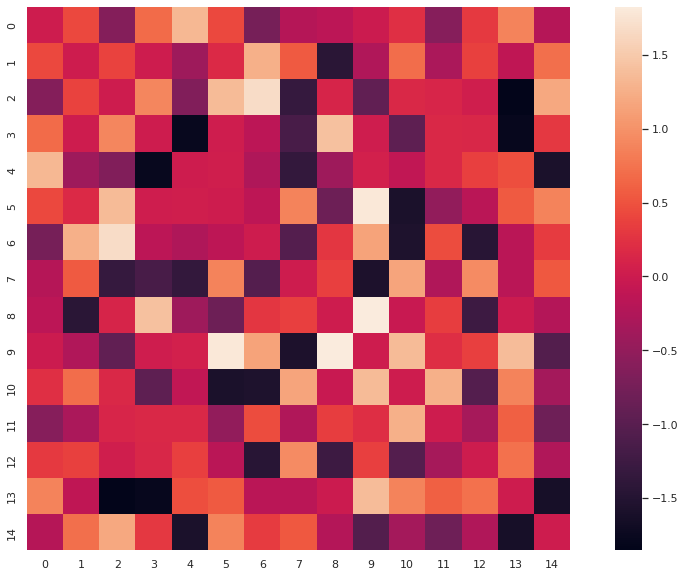

In [14]:
model.model_summary()

#### **Exact Analysis**

In [15]:
## set current beta
beta = 1.100209

## run exact sampling over all possible configurations 
model.run_exact_sampling(beta)

Running Exact Sampling | Model beta :  1.100209


running over all possible configurations: 100%|██████████| 32768/32768 [00:00<00:00, 47755.72it/s]


saving distribution to model ...


In [16]:
model.exact_sampling_status

True

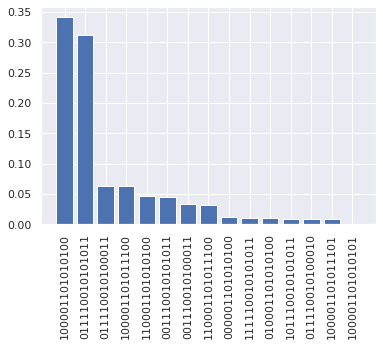

In [17]:
## get the distribution from model
bpd = model.boltzmann_pd

## plot the distribution
plot_bargraph_desc_order(bpd, label= 'Boltzmann Dist.', plot_first_few= 15)

#### **Run Classical MCMC**

In [18]:
steps = 5000
config_counts_c, proposed_states_c, accepted_states_c =classical_mcmc(
    N_hops=steps,
    model=model,
    return_last_n_states=10,
    return_additional_lists=True,
    temp=1/beta,
)

trajectory_c = trajectory_processing(accepted_states_c)

starting with:  110001111001011


running MCMC steps ...: 100%|██████████| 5000/5000 [00:00<00:00, 14634.04it/s]


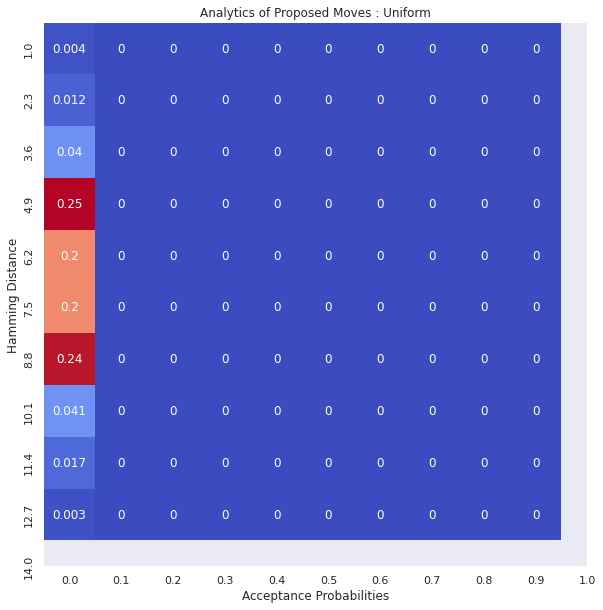

In [28]:
energy_diff = []; hamming_diff= []; transition_probs= []
proposed_states = proposed_states_c
accepted_states = accepted_states_c

for s in range(len(accepted_states)-1):
    hamming_diff.append(hamming_dist(proposed_states[s+1], accepted_states[s]))
    transition_probs.append( min(1, model.get_boltzmann_prob(proposed_states[s+1]) / model.get_boltzmann_prob(accepted_states[s])) )

# plt.scatter(transition_probs, hamming_diff)

fills, xticks, yticks = np.histogram2d(transition_probs, hamming_diff, density= True)
fills = fills / np.sum(fills)
plt.figure(figsize=(10,10))
sns.heatmap(np.round(fills.transpose(), decimals=3), square= True, xticklabels= np.round( xticks, decimals= 1) , yticklabels= np.round( yticks, decimals= 1), cmap="coolwarm", cbar= False, annot= True)
plt.xlabel("Acceptance Probabilities")
plt.ylabel("Hamming Distance")
plt.title("Analytics of Proposed Moves : Uniform")
plt.show()

#### **Run Quantum Enhaned MCMC**

In [20]:
steps = 5000
config_counts_q, proposed_states_q, accepted_states_q =quantum_enhanced_mcmc(
    N_hops=steps,
    model=model,
    return_last_n_states=10,
    return_additional_lists=True,
    temp=1/beta,
)

trajectory_q = trajectory_processing(accepted_states_q)

starting with:  110000101000000


runnning quantum MCMC steps . ..: 100%|██████████| 5000/5000 [34:05<00:00,  2.44it/s]


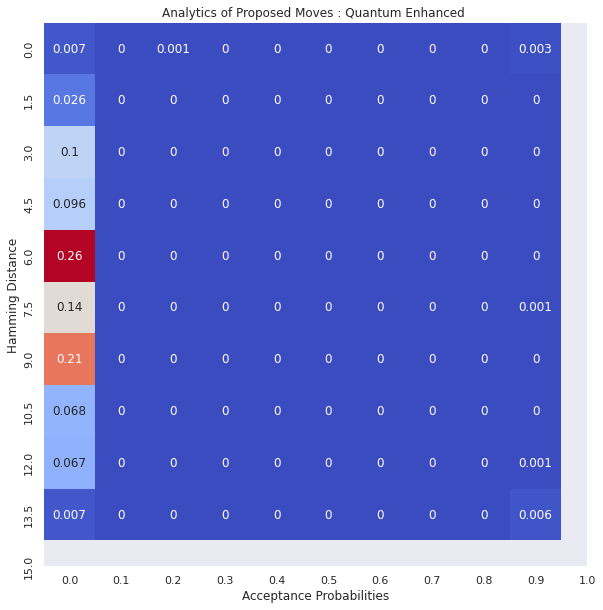

In [21]:
energy_diff = []; hamming_diff= []; transition_probs= []
proposed_states = proposed_states_q
accepted_states = accepted_states_q

for s in range(len(accepted_states)-1):
    hamming_diff.append(hamming_dist(proposed_states[s+1], accepted_states[s]))
    transition_probs.append( min(1, model.get_boltzmann_prob(proposed_states[s+1]) / model.get_boltzmann_prob(accepted_states[s])) )

# plt.scatter(transition_probs, hamming_diff)

fills, xticks, yticks = np.histogram2d(transition_probs, hamming_diff, density= True)
fills = fills / np.sum(fills)
plt.figure(figsize=(10,10))
sns.heatmap(np.round(fills.transpose(), decimals=3), square= True, xticklabels= np.round( xticks, decimals= 1) , yticklabels= np.round( yticks, decimals= 1), cmap="coolwarm", cbar= False, annot= True)
plt.xlabel("Acceptance Probabilities")
plt.ylabel("Hamming Distance")
plt.title("Analytics of Proposed Moves : Quantum Enhanced ")
plt.show()

#### **Convergence Analysis**

##### Magnetisation

In [22]:
magnetization_model = model.get_observable_expectation(magnetization_of_state)
magnetization_c = trajectory_c.running_avg_magnetization_as_list()
magnetization_q = trajectory_q.running_avg_magnetization_as_list()

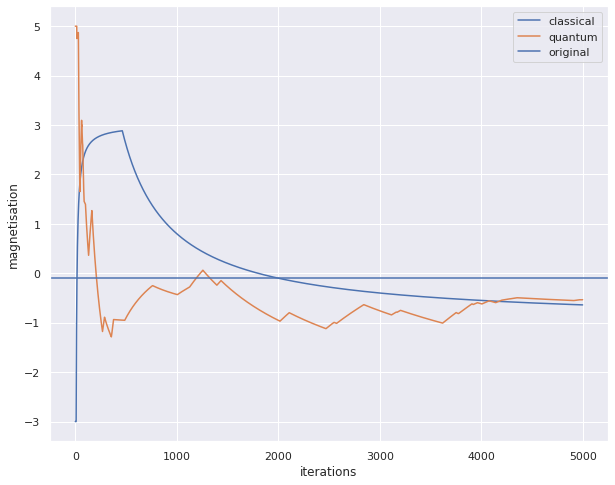

In [32]:
plt.figure(figsize=(10,8))
plt.plot(magnetization_c, label= 'classical')
plt.plot(magnetization_q, label= 'quantum')
plt.axhline(magnetization_model, label= 'original')
plt.xlabel("iterations")
plt.ylabel("magnetisation")
plt.legend()
plt.show()

##### JS Divergence

In [24]:
jsdiv_c = trajectory_c.running_js_divergence(model.boltzmann_pd)

  0%|          | 0/245 [00:00<?, ?it/s]/home/rajarsi/Documents/QBMS/qumcmc/qumcmc/prob_dist.py:112: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum(np.where(p_arr>10**-6,p_arr*np.log2(p_arr/q_arr),0.))
/home/rajarsi/Documents/QBMS/qumcmc/qumcmc/prob_dist.py:112: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(np.where(p_arr>10**-6,p_arr*np.log2(p_arr/q_arr),0.))
/home/rajarsi/Documents/QBMS/qumcmc/qumcmc/prob_dist.py:112: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(p_arr>10**-6,p_arr*np.log2(p_arr/q_arr),0.))
/home/rajarsi/Documents/QBMS/qumcmc/qumcmc/prob_dist.py:112: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p_arr>10**-6,p_arr*np.log2(p_arr/q_arr),0.))
100%|██████████| 245/245 [02:02<00:00,  1.99it/s]


In [25]:
jsdiv_q = trajectory_q.running_js_divergence(model.boltzmann_pd)

100%|██████████| 245/245 [01:54<00:00,  2.14it/s]


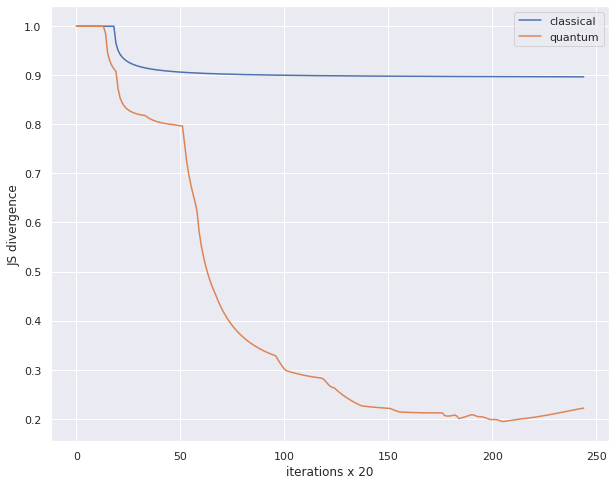

In [33]:
plt.figure(figsize=(10,8))
plt.plot(jsdiv_c, label= 'classical')
plt.plot(jsdiv_q, label= 'quantum')
plt.xlabel("iterations x 20")
plt.ylabel("JS divergence")
plt.legend()
plt.show()
